In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, precision_recall_curve

ImportError: Unable to import required dependencies:
numpy: No module named 'numpy._core.multiarray'

In [104]:
#loading data and renaming
df = pd.read_excel('default of credit card clients.xls', header=1)
df.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)

In [105]:
#data cleaning education and marriage
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)

Data Loaded, Cleaned, and Features Created!


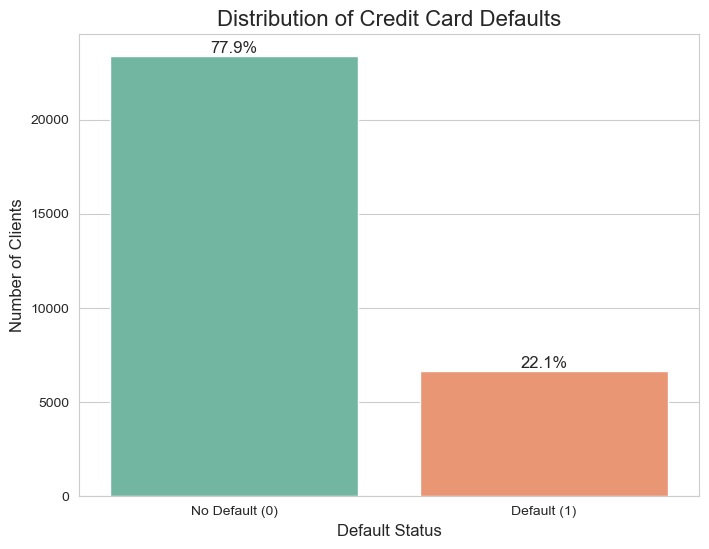

In [106]:
#EDA
sns.set_style("whitegrid")

#viz 1: class imbalance
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='DEFAULT', data=df, palette='Set2')
plt.title('Distribution of Credit Card Defaults', fontsize=16)
plt.xlabel('Default Status', fontsize=12)
plt.ylabel('Number of Clients', fontsize=12)
ax.set_xticklabels(['No Default (0)', 'Default (1)'])

total = len(df['DEFAULT'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

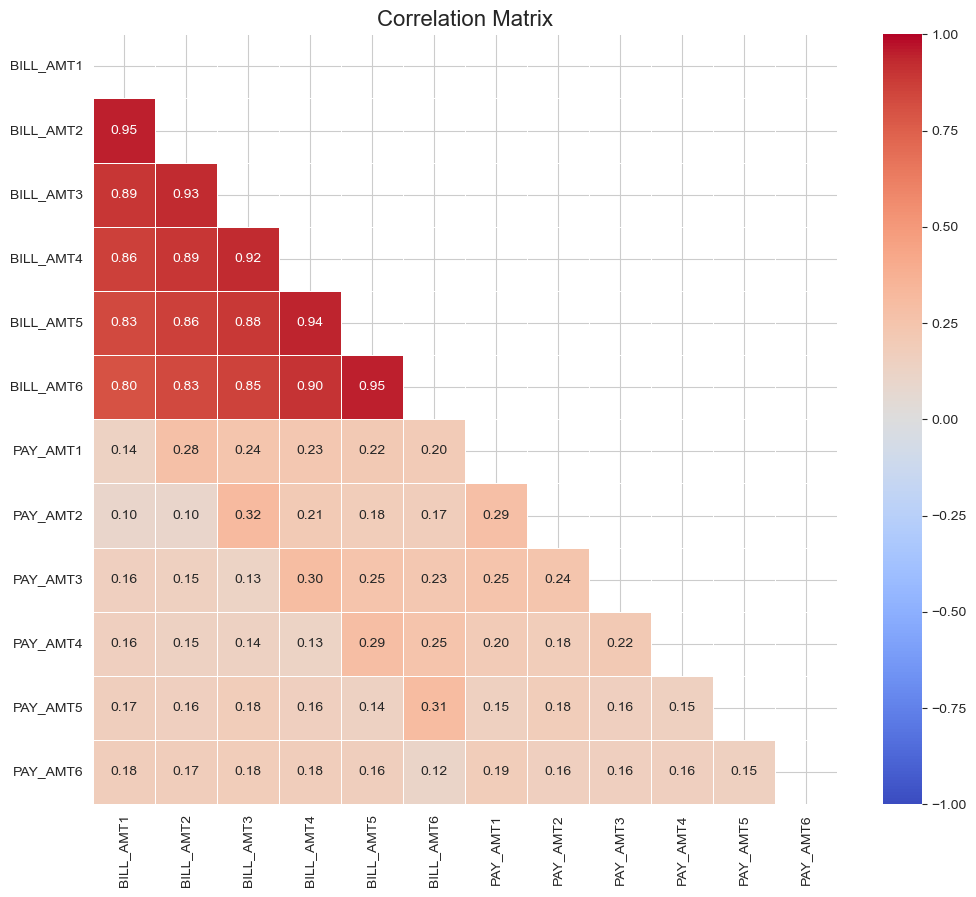

In [107]:
#viz 2: correlation matrix of bill amount and payment amount

financial_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                  'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

corr = df[financial_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool)) # Hides the upper triangle (optional but cleaner)

sns.heatmap(
    corr, 
    mask=mask,
    cmap='coolwarm', 
    annot=True, 
    fmt=".2f", 
    linewidths=.5,
    vmin=-1, vmax=1
)
plt.title('Correlation Matrix', fontsize=16)
plt.show()


In [ ]:
#viz 3: violin plot of education feature and limit balance (raw)

sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

ax = sns.violinplot(
    x='EDUCATION',
    y='LIMIT_BAL',
    hue='DEFAULT',      
    data=df,
    split=False,        
    inner="box",        
    palette={0: "#4c72b0", 1: "#dd8452"}
)

plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Credit Limit (NT Dollars)', fontsize=12)
plt.title(
    'Credit Limit Distribution by Education and Default Status',
    fontsize=16
)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax.set_xticklabels(['Graduate School', 'University', 'High School', 'Other'])

overall_median = df['LIMIT_BAL'].median()
plt.axhline(
    overall_median,
    color='grey',
    linestyle='--',
    linewidth=1.5,
    label=f'Overall Median ({overall_median:,.0f})'
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=[handles[0], handles[1]],
    labels=['No Default', 'Default'],
    title='Default Status',
    loc='upper right'
)

plt.show()


In [ ]:
#viz 4: violin plot of education feature and limit balance (logged)

if 'LIMIT_BAL_LOG' not in df.columns:
    df['LIMIT_BAL_LOG'] = np.log(df['LIMIT_BAL'] + 1)

sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

ax = sns.violinplot(
    x='EDUCATION',
    y='LIMIT_BAL_LOG',
    hue='DEFAULT',      
    data=df,
    split=False,        
    inner="box",        
    palette={0: "#4c72b0", 1: "#dd8452"}
)

plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Credit Limit (NT Dollars, Log Scale)', fontsize=12)
plt.title(
    'Log-Transformed Credit Limit Distribution by Education and Default Status',
    fontsize=16
)

formatter = mtick.FuncFormatter(lambda x, p: f'{int(np.exp(x)):,}')
ax.yaxis.set_major_formatter(formatter)

ax.set_xticklabels(['Graduate School', 'University', 'High School', 'Other'])

overall_median_log = df['LIMIT_BAL_LOG'].median()
overall_median_dollars = int(np.exp(overall_median_log))
plt.axhline(
    overall_median_log,
    color='grey',
    linestyle='--',
    linewidth=1.5,
    label=f'Overall Median ({overall_median_dollars:,})'
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=[handles[0], handles[1]],
    labels=['No Default', 'Default'],
    title='Default Status',
    loc='upper right'
)

plt.show()


In [108]:
#preprocessing
if 'ID' in df.columns:
    df.drop(columns=['ID'], inplace=True)

# create average features for bill amt and pay amt
df['AVG_BILL'] = df[[f'BILL_AMT{i}' for i in range(1, 7)]].mean(axis=1)
df['AVG_PAY'] = df[[f'PAY_AMT{i}' for i in range(1, 7)]].mean(axis=1)

# create util ratio
df['UTILIZATION'] = (df['AVG_BILL'] / df['LIMIT_BAL']).clip(lower=0)

# log transform financial features
for col in ['LIMIT_BAL', 'AVG_BILL', 'AVG_PAY']:
    min_val = df[col].min()
    shift = abs(min_val) + 1 if min_val < 0 else 1
    df[f'{col}_LOG'] = np.log(df[col] + shift)



Running Clustering on Scaled Data...


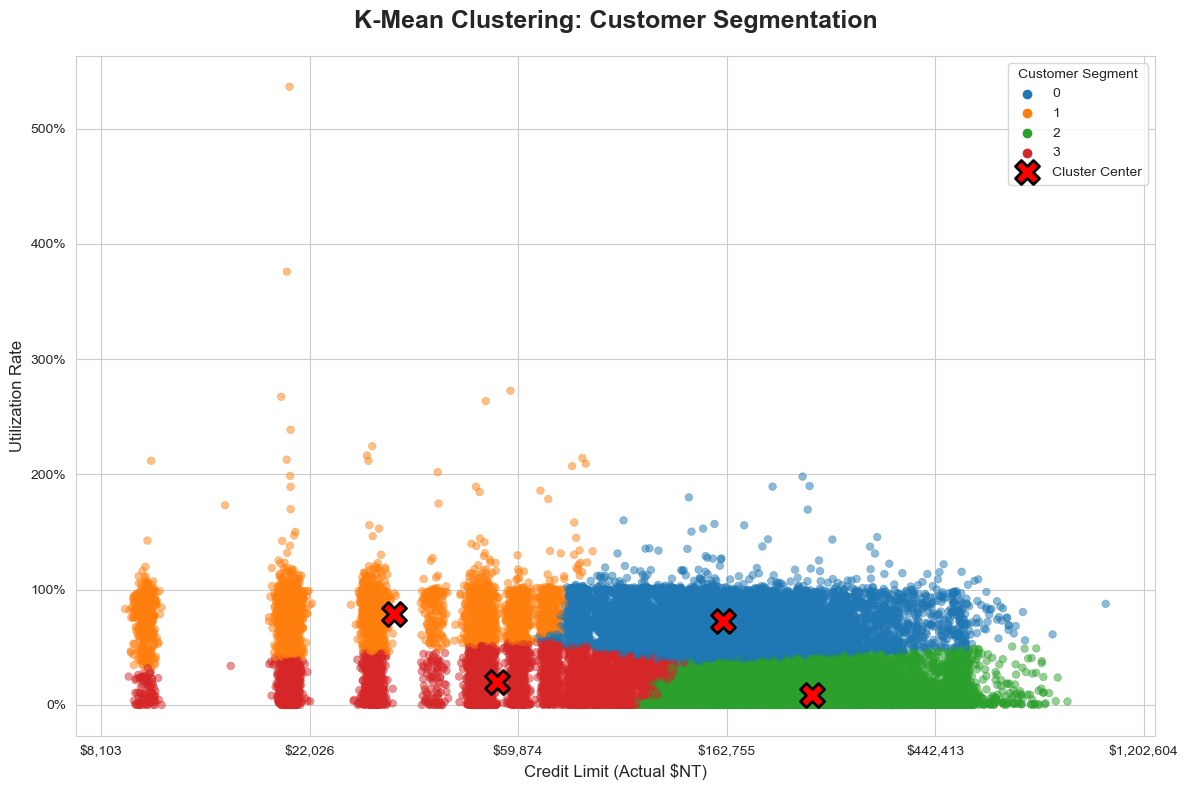

In [109]:
#unsupervised model, K Means
X_cluster = df[['LIMIT_BAL_LOG', 'UTILIZATION']]
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# dropping redundant cols
drop_cols = financial_cols + ['LIMIT_BAL', 'AVG_BILL', 'AVG_PAY']
X = df.drop(columns=drop_cols + ['DEFAULT'])
y = df['DEFAULT']

#encoding
X = pd.get_dummies(X, columns=['SEX', 'EDUCATION', 'MARRIAGE', 'Cluster'], drop_first=True)

#use the Log Limit and utilization ratio
X_cluster = df[['LIMIT_BAL_LOG', 'UTILIZATION']]

#scaling
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

#running model
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

#added jitter to see clusters better
jitter_x = df['LIMIT_BAL_LOG'] + np.random.normal(0, 0.03, size=len(df))

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

ax = sns.scatterplot(
    x=jitter_x, 
    y='UTILIZATION', 
    hue='Cluster', 
    data=df, 
    palette='tab10', 
    alpha=0.5,      
    s=30,          
    edgecolor=None 
)

#plot centeroids
centroids = df.groupby('Cluster')[['LIMIT_BAL_LOG', 'UTILIZATION']].mean()
plt.scatter(
    centroids['LIMIT_BAL_LOG'], centroids['UTILIZATION'], 
    c='red', s=300, alpha=1, marker='X', 
    label='Cluster Center', edgecolors='black', linewidths=2, zorder=10
)

#formatting
ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: '${:,.0f}'.format(np.exp(x)))
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))



plt.title('K-Mean Clustering: Customer Segmentation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Credit Limit (Actual $NT)', fontsize=12)
plt.ylabel('Utilization Rate', fontsize=12)
plt.legend(title='Customer Segment', loc='upper right')

plt.tight_layout()
plt.show()


Testing different cluster counts...


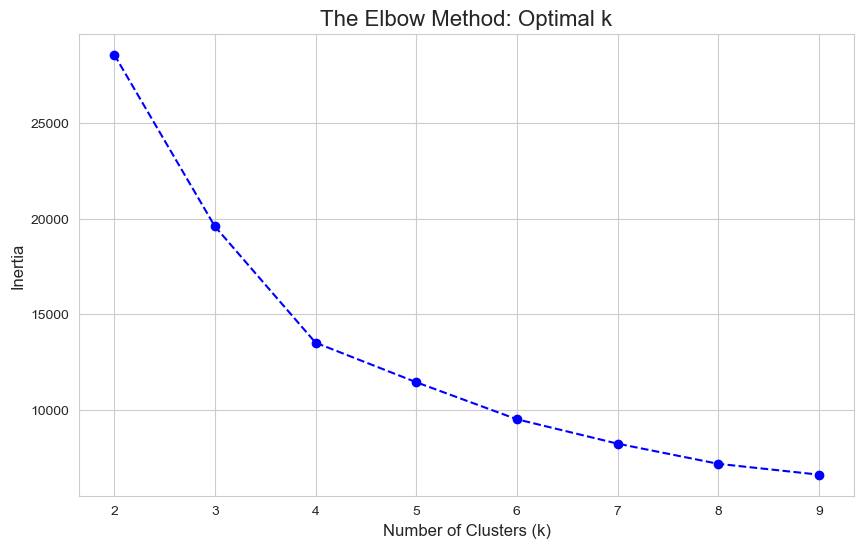

In [110]:
#elbow plot
inertia = []
K_range = range(2, 10)


for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(X_cluster_scaled) # Use the SCALED data!
    inertia.append(kmeans_test.inertia_)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')

plt.title('The Elbow Method: Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(K_range)
plt.show()



>>> CLUSTER RISK PROFILE <<<
         Client Count  Default Rate
Cluster                            
1                5620     33.487544
3                5575     25.524664
0                6330     23.096367
2               12475     14.981964


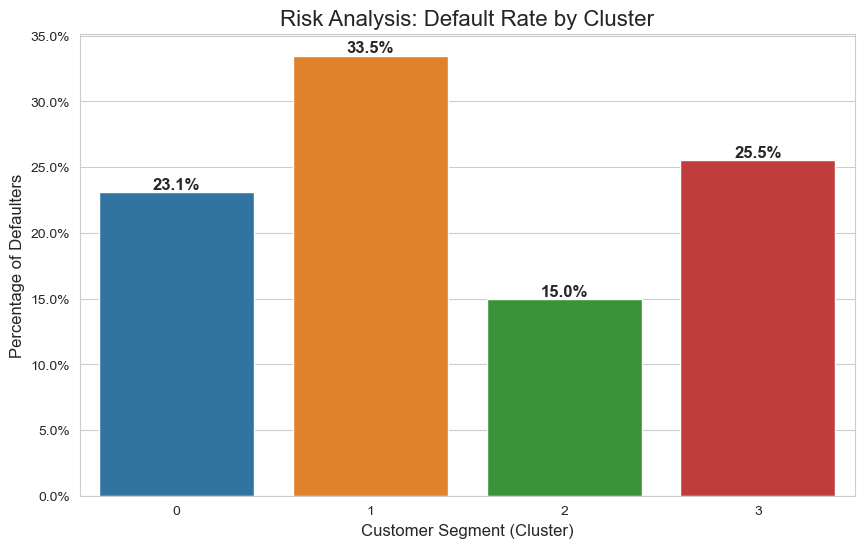

In [111]:
#calc default rate per cluster
cluster_profile = df.groupby('Cluster')['DEFAULT'].agg(['count', 'mean'])
cluster_profile.columns = ['Client Count', 'Default Rate']
cluster_profile['Default Rate'] = cluster_profile['Default Rate'] * 100 # Convert to %

print("\n>>> CLUSTER RISK PROFILE <<<")
print(cluster_profile.sort_values(by='Default Rate', ascending=False))

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

#making bar chart
ax = sns.barplot(
    x=cluster_profile.index, 
    y=cluster_profile['Default Rate'], 
    palette='tab10'
)

#formatting
plt.title('Risk Analysis: Default Rate by Cluster', fontsize=16)
plt.xlabel('Customer Segment (Cluster)', fontsize=12)
plt.ylabel('Percentage of Defaulters', fontsize=12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

In [112]:
#supervised models 
#more preprocessing
cols_to_drop = ['DEFAULT', 'LIMIT_BAL', 'AVG_BILL', 'AVG_PAY'] + \
               [f'BILL_AMT{i}' for i in range(1, 7)] + \
               [f'PAY_AMT{i}' for i in range(1, 7)]

X = df.drop(columns=cols_to_drop)
y = df['DEFAULT']

#one hot encoding
X = pd.get_dummies(X, columns=['SEX', 'EDUCATION', 'MARRIAGE', 'Cluster'], drop_first=True)


# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#scale training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




Final Features: ['AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'UTILIZATION', 'LIMIT_BAL_LOG', 'AVG_BILL_LOG', 'AVG_PAY_LOG', 'SEX_2', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_2', 'MARRIAGE_3', 'Cluster_1', 'Cluster_2', 'Cluster_3']

Data Split & Scaled!
Training Shape: (24000, 20)
Testing Shape:  (6000, 20)


In [113]:
saved_models = {}

#vanilla lr
print("Vanilla Logistic Regression")
lr_vanilla = LogisticRegression(max_iter=1000, random_state=42)
lr_vanilla.fit(X_train_scaled, y_train)

#metrics
y_pred = lr_vanilla.predict(X_test_scaled)
y_prob = lr_vanilla.predict_proba(X_test_scaled)[:, 1]
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.2%} | AUC: {auc:.3f}")
print("\n Metrics")
print(classification_report(y_test, y_pred))
print("-" * 60)

saved_models['Vanilla LR'] = lr_vanilla

Vanilla Logistic Regression
Accuracy: 80.55% | AUC: 0.727

 Metrics
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.67      0.24      0.35      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.60      0.62      6000
weighted avg       0.78      0.81      0.77      6000

------------------------------------------------------------


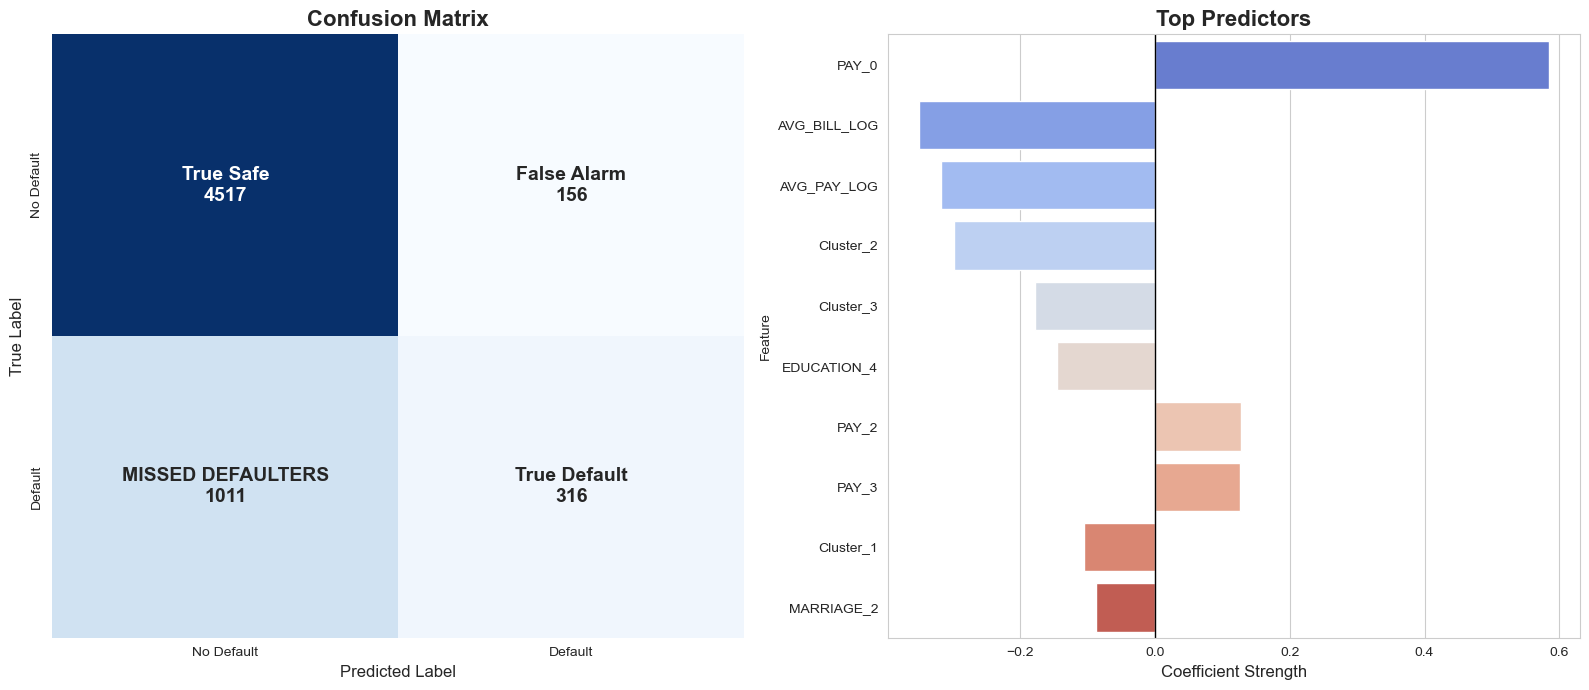

In [123]:
#plotting
lr_model = saved_models['Vanilla LR']
y_pred_vanilla = lr_model.predict(X_test_scaled)

# get coefficients
coeffs = lr_model.coef_[0]
feature_names = X.columns
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})
coeff_df['Abs_Coeff'] = coeff_df['Coefficient'].abs()
top_10 = coeff_df.sort_values(by='Abs_Coeff', ascending=False).head(10)

#plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_style("whitegrid") # Back to the style you liked

# confusion matrix
cm = confusion_matrix(y_test, y_pred_vanilla)

#labels in cm
labels = np.array([
    [f"True Safe\n{cm[0,0]}", f"False Alarm\n{cm[0,1]}"],
    [f"MISSED DEFAULTERS\n{cm[1,0]}", f"True Default\n{cm[1,1]}"]
])

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[0], cbar=False, 
            annot_kws={"size": 14, "weight": "bold"})

axes[0].set_title('Confusion Matrix', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['No Default', 'Default'])
axes[0].set_yticklabels(['No Default', 'Default'])



#plot of feature coefficients
sns.barplot(x='Coefficient', y='Feature', data=top_10, palette='coolwarm', ax=axes[1])

axes[1].set_title('Top Predictors', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Coefficient Strength', fontsize=12)
axes[1].axvline(0, color='black', linewidth=1) # Zero line

plt.tight_layout()
plt.show()

In [115]:
#tuned lr
print("\nTuned Logistic Regression")
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'class_weight': ['balanced'],
    'solver': ['lbfgs']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=3, scoring='f1')
grid_lr.fit(X_train_scaled, y_train)

best_lr = grid_lr.best_estimator_

#metrics
y_pred = best_lr.predict(X_test_scaled)
y_prob = best_lr.predict_proba(X_test_scaled)[:, 1]
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"   Best Params: {grid_lr.best_params_}")
print(f"   Accuracy: {acc:.2%} | AUC: {auc:.3f}")
print("\nMetrics")
print(classification_report(y_test, y_pred))
print("-" * 60)

saved_models['Tuned LR'] = best_lr



Tuned Logistic Regression
   Best Params: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
   Accuracy: 70.30% | AUC: 0.729

Metrics
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      4673
           1       0.39      0.63      0.48      1327

    accuracy                           0.70      6000
   macro avg       0.63      0.68      0.64      6000
weighted avg       0.77      0.70      0.72      6000

------------------------------------------------------------


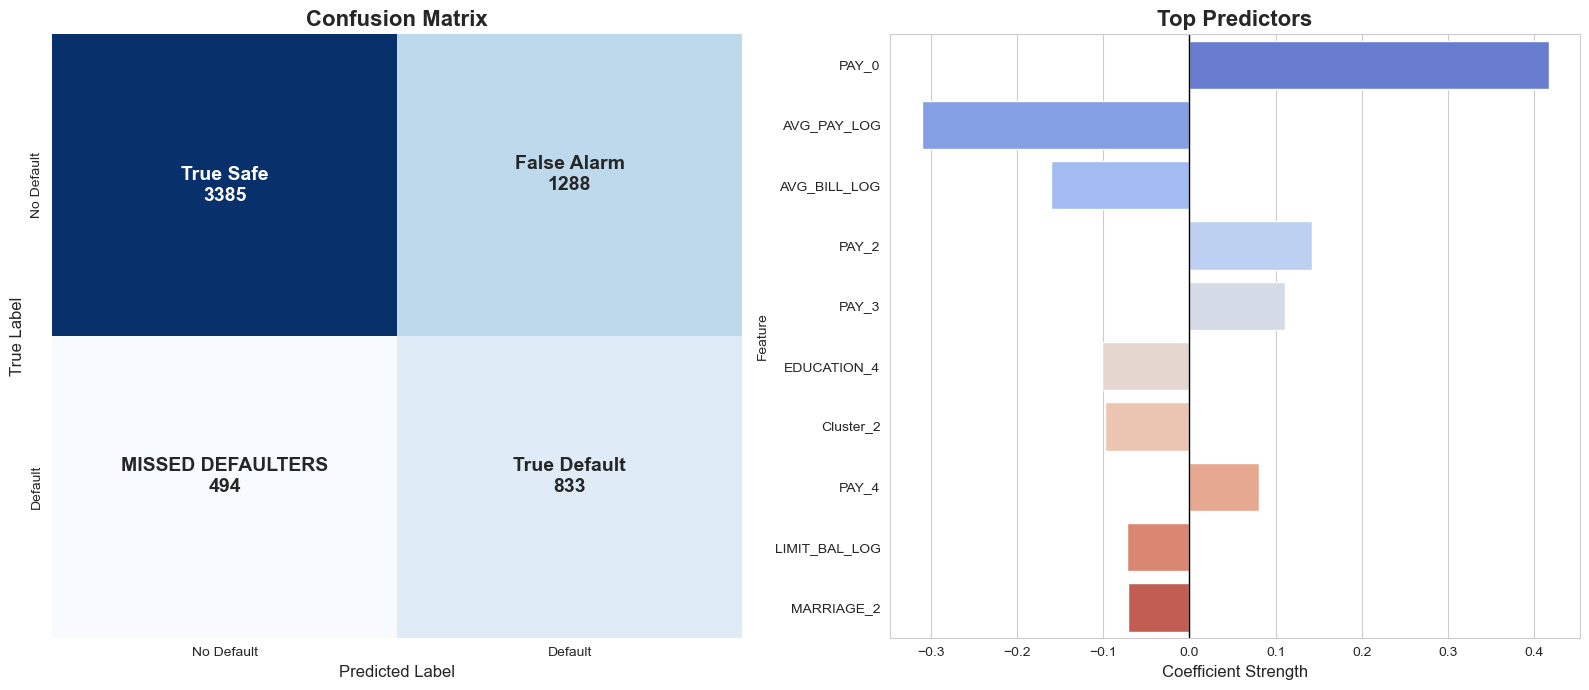

In [124]:
#plotting
lr_tuned = saved_models['Tuned LR']
y_pred_tuned = lr_tuned.predict(X_test_scaled)

#get coefficients
coeffs = lr_tuned.coef_[0]
feature_names = X.columns
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})
coeff_df['Abs_Coeff'] = coeff_df['Coefficient'].abs()
top_10 = coeff_df.sort_values(by='Abs_Coeff', ascending=False).head(10)

# confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_style("whitegrid")

cm = confusion_matrix(y_test, y_pred_tuned)

# labels
labels = np.array([
    [f"True Safe\n{cm[0,0]}", f"False Alarm\n{cm[0,1]}\n"],
    [f"MISSED DEFAULTERS\n{cm[1,0]}\n", f"True Default\n{cm[1,1]}\n"]
])

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[0], cbar=False, 
            annot_kws={"size": 14, "weight": "bold"})

axes[0].set_title('Confusion Matrix', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['No Default', 'Default'])
axes[0].set_yticklabels(['No Default', 'Default'])



#feature coefficients plot
sns.barplot(x='Coefficient', y='Feature', data=top_10, palette='coolwarm', ax=axes[1])

axes[1].set_title('Top Predictors', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Coefficient Strength', fontsize=12)
axes[1].axvline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()


In [117]:
#vanilla rf
print("\nVanilla Random Forest")
rf_vanilla = RandomForestClassifier(random_state=42)
rf_vanilla.fit(X_train_scaled, y_train)

# metrics
y_pred = rf_vanilla.predict(X_test_scaled)
y_prob = rf_vanilla.predict_proba(X_test_scaled)[:, 1]
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.2%} | AUC: {auc:.3f}")
print("\nMetrics")
print(classification_report(y_test, y_pred))
print("-" * 60)

saved_models['Vanilla RF'] = rf_vanilla


Vanilla Random Forest
Accuracy: 81.25% | AUC: 0.755

Metrics
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.64      0.35      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

------------------------------------------------------------


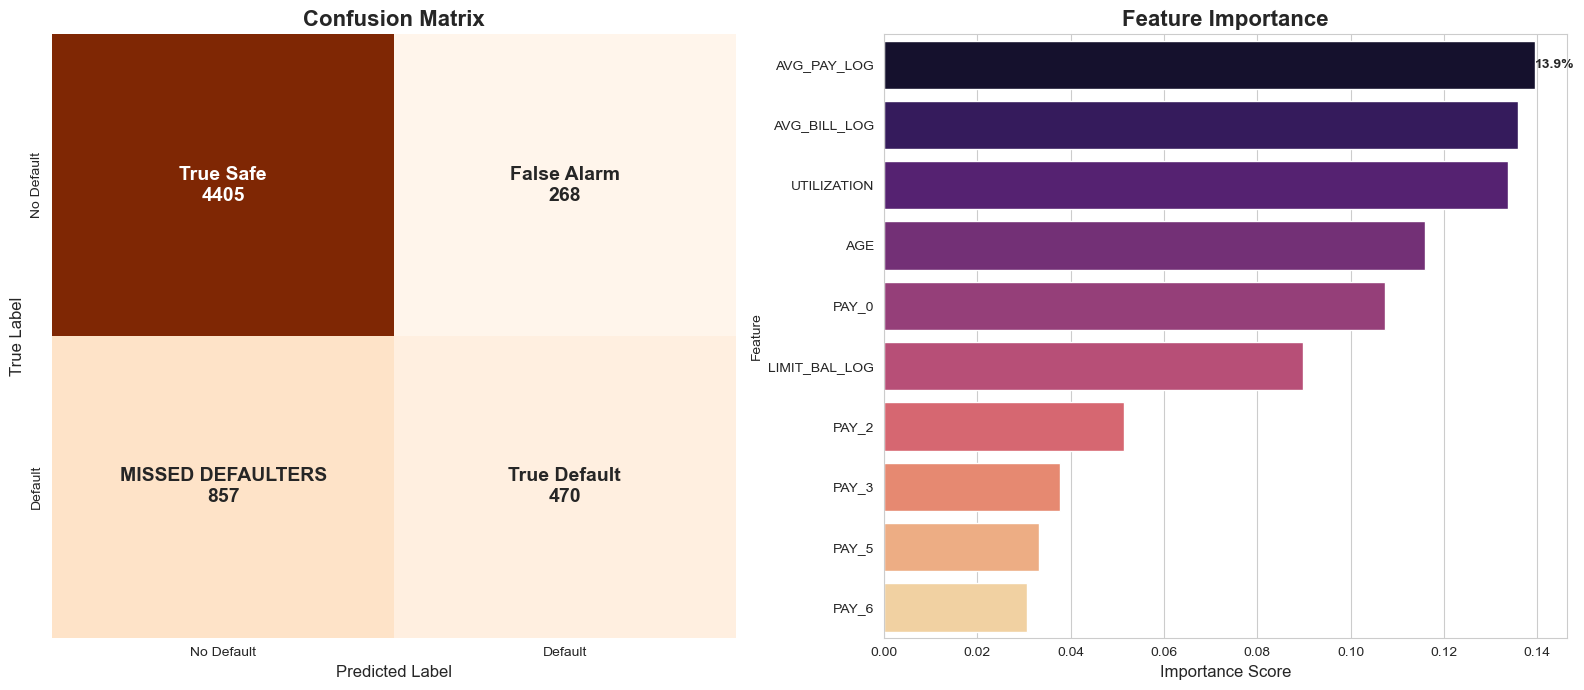

In [125]:
#plotting
rf_model = saved_models['Vanilla RF']
y_pred_rf = rf_model.predict(X_test_scaled)

#get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort by importance
top_10 = feat_df.sort_values(by='Importance', ascending=False).head(10)

#confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_style("whitegrid")

cm = confusion_matrix(y_test, y_pred_rf)

#Labels
labels = np.array([
    [f"True Safe\n{cm[0,0]}", f"False Alarm\n{cm[0,1]}"],
    [f"MISSED DEFAULTERS\n{cm[1,0]}", f"True Default\n{cm[1,1]}"]
])

sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', ax=axes[0], cbar=False, 
            annot_kws={"size": 14, "weight": "bold"})

axes[0].set_title('Confusion Matrix', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['No Default', 'Default'])
axes[0].set_yticklabels(['No Default', 'Default'])




#feature importance plot
sns.barplot(x='Importance', y='Feature', data=top_10, palette='magma', ax=axes[1])

axes[1].set_title('Feature Importance', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Importance Score', fontsize=12)

top_val = top_10.iloc[0]['Importance']
axes[1].text(top_val, 0, f'{top_val:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [127]:
#tuned rf
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [2, 5],
    'class_weight': ['balanced']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1), 
    rf_params, 
    cv=3, 
    scoring='f1'
)

grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_

# finding optimal threshold
y_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# final predictions
y_pred_optimized = (y_prob >= best_threshold).astype(int)

#metrics
auc_score = roc_auc_score(y_test, y_prob)
acc_score = accuracy_score(y_test, y_pred_optimized)

print("\nTuned Random Forest")
print(f"Best Params: {grid_rf.best_params_}")
print(f"Optimal Threshold: {best_threshold:.2f}")
print(f"Accuracy: {acc_score:.2%} | AUC: {auc_score:.3f}")

print("\nMetrics")
print(classification_report(y_test, y_pred_optimized))

saved_models['Tuned RF'] = best_rf





Tuned Random Forest
Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}
Optimal Threshold: 0.47
Accuracy: 77.60% | AUC: 0.775

Metrics
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      4673
           1       0.49      0.60      0.54      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.79      0.78      0.78      6000



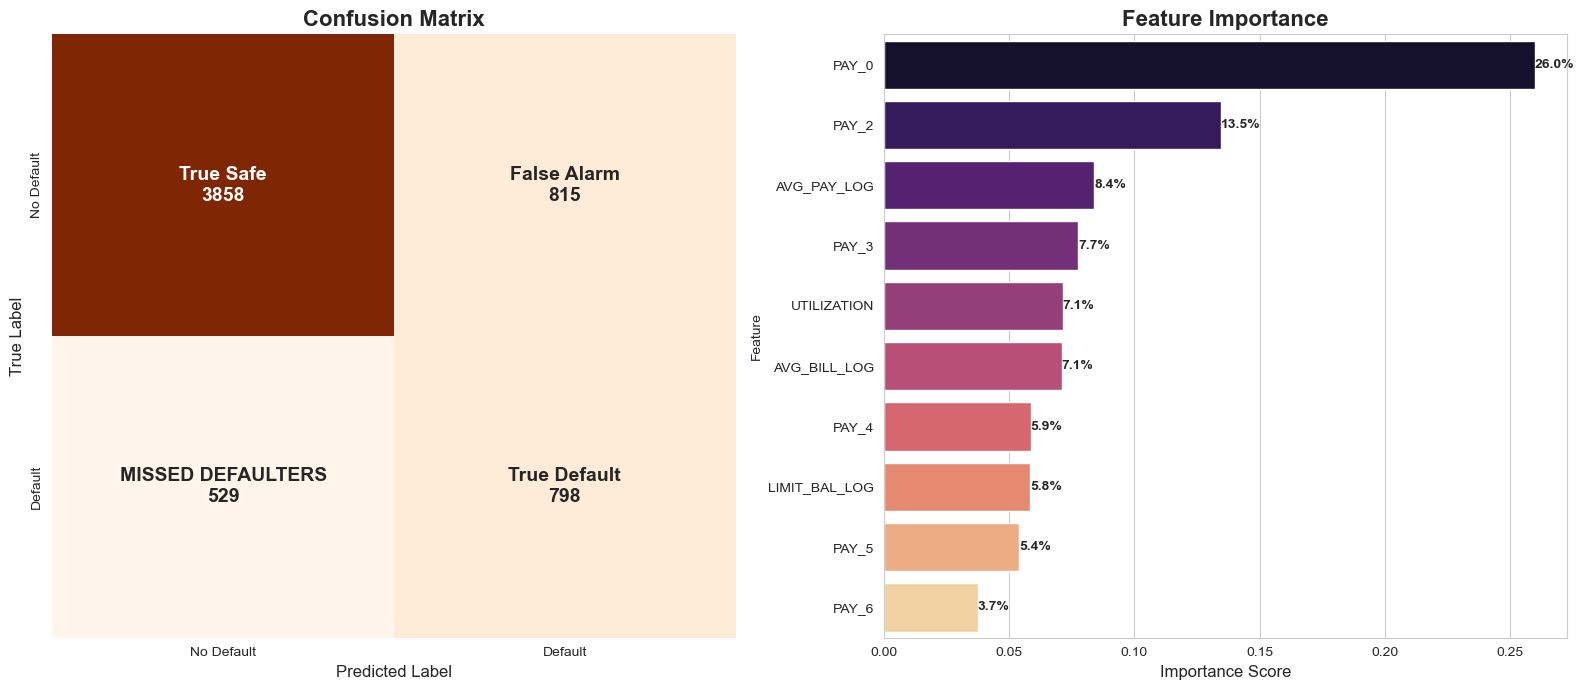

In [126]:
#plotting
rf_final = saved_models['Tuned RF']
y_prob_final = rf_final.predict_proba(X_test_scaled)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_final)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

#generate predictions using the custom threshold
y_pred_final = (y_prob_final >= best_threshold).astype(int)

#get feature importances
importances = rf_final.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_10 = feat_df.sort_values(by='Importance', ascending=False).head(10)

#confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_style("whitegrid")

cm = confusion_matrix(y_test, y_pred_final)

recall_score = cm[1,1] / (cm[1,1] + cm[1,0])

# Labels
labels = np.array([
    [f"True Safe\n{cm[0,0]}", f"False Alarm\n{cm[0,1]}"],
    [f"MISSED DEFAULTERS\n{cm[1,0]}", f"True Default\n{cm[1,1]}"]
])

sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', ax=axes[0], cbar=False, 
            annot_kws={"size": 14, "weight": "bold"})

axes[0].set_title(f'Confusion Matrix', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['No Default', 'Default'])
axes[0].set_yticklabels(['No Default', 'Default'])




#feature importance
sns.barplot(x='Importance', y='Feature', data=top_10, palette='magma', ax=axes[1])

axes[1].set_title('Feature Importance', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Importance Score', fontsize=12)

for i, v in enumerate(top_10['Importance']):
    axes[1].text(v, i, f'{v:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()
